In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
bigp = [
    'BNP', 'Jamaat', 'JaPa', 'Islami Andolan Bangladesh',
    'GOP (Nuru)', 'Bangladesh Khelafat Majlish', 'Khelafat Majlish',
    'CPB', 'AB Party', 'NCP', 'Independent'
]
mainp = ['BNP', 'Jamaat', 'JaPa', 'NCP', 'Independent']

In [3]:
bdmap = gpd.read_file('map/seats.shp')
bdmap.head()

,seat_no,seat,district,division,region,shape_len,shape_area,geometry
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."
2,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788..."
3,4,Thakurgaon-2,Thakurgaon,Rangpur,Rural,1.858839,0.045806,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,..."
4,5,Thakurgaon-3,Thakurgaon,Rangpur,Rural,1.810654,0.059069,"POLYGON ((88.25475 26.03583, 88.25828 26.03391..."


In [4]:
dfa = pd.read_csv('data/affidavit.csv')
dfa = dfa[['filename', 'name_bn', 'zillaID', 'constituencyID', 'income', 'tax', 'wealth', 'party']]
dfa.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party
0,"1,109,মশিউর রহমান.txt",মশিউর রহমান,1,109,NaN,NaN,NaN,Independent
1,"1,109,মোঃ অলি উল্লাহ.txt",মোঃ অলি উল্লাহ,1,109,800000.0,45000.0,NaN,Islami Andolan Bangladesh
2,"1,109,মোঃ জামাল হোসাইন.txt",মোঃ জামাল হোসাইন,1,109,5000.0,5000.0,713000.0,JP (Manju)
3,"1,109,মোঃ জাহাঙ্গীর হোসাইন.txt",মোঃ জাহাঙ্গীর হোসাইন,1,109,471500.0,7150.0,3890900.0,Khelafat Majlish
4,"1,109,মোঃ মুহিব্বুল্যাহ.txt",মোঃ মুহিব্বুল্যাহ,1,109,NaN,NaN,NaN,Jamaat


In [5]:
dfa.shape

(2446, 8)

In [8]:
def get_exemption(income):
    return min(income/3, 500000)

def get_taxable_income(income):
    return income - get_exemption(income)

tax_slab = [
    (375000, 0),
    (300000, 0.1),
    (400000, 0.15),
    (500000, 0.2),
    (2000000, 0.25),
    (float('inf'), 0.3)
]

def get_tax_liability(taxable):
    tax_liability = []
    balance = taxable + 0
    for slab, rate in tax_slab:
        if balance == 0:
            break
        slab_amnt = min(slab, balance)
        slab_tax_amnt = slab_amnt*rate
        tax_liability.append(slab_tax_amnt)
        balance = max(0, balance - slab)
    return max(5000, sum(tax_liability))
        
def get_rebate_excluding_investment(taxable, liability):
    taxable_3pc = taxable*0.03
    rebate_max = 1000000
    return min(taxable_3pc, rebate_max)

def check_tax_paid(row):
    tax = row.tax
    income = row.income
    wealth = row.wealth
    taxable_income = get_taxable_income(income)
    tax_liability = get_tax_liability(taxable_income)
    rebate = max(0, tax_liability-tax)
    rebate_excluding_investment = get_rebate_excluding_investment(taxable_income, tax_liability)
    if rebate > rebate_excluding_investment:
        investment = rebate/0.15
        inv_perc = round(investment/wealth, 2)
        return inv_perc
    return 0

In [9]:
dfa['check_tax'] = dfa.apply(check_tax_paid, axis=1)
dfa.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party,check_tax
0,"1,109,মশিউর রহমান.txt",মশিউর রহমান,1,109,NaN,NaN,NaN,Independent,0.0
1,"1,109,মোঃ অলি উল্লাহ.txt",মোঃ অলি উল্লাহ,1,109,800000.0,45000.0,NaN,Islami Andolan Bangladesh,0.0
2,"1,109,মোঃ জামাল হোসাইন.txt",মোঃ জামাল হোসাইন,1,109,5000.0,5000.0,713000.0,JP (Manju),0.0
3,"1,109,মোঃ জাহাঙ্গীর হোসাইন.txt",মোঃ জাহাঙ্গীর হোসাইন,1,109,471500.0,7150.0,3890900.0,Khelafat Majlish,0.0
4,"1,109,মোঃ মুহিব্বুল্যাহ.txt",মোঃ মুহিব্বুল্যাহ,1,109,NaN,NaN,NaN,Jamaat,0.0


In [10]:
dfa.check_tax.value_counts()

check_tax
0.00    2270
0.02      10
0.01       8
0.03       6
0.12       5
0.07       4
0.06       4
0.05       4
0.91       3
0.04       3
0.22       2
0.23       2
0.61       2
0.13       2
0.27       2
0.08       1
0.31       1
1.29       1
0.71       1
1.22       1
0.11       1
0.17       1
0.18       1
0.14       1
0.34       1
0.67       1
1.07       1
0.81       1
1.17       1
0.39       1
1.30       1
Name: count, dtype: int64

In [11]:
dfnottax = dfa[dfa['check_tax']>0.5].sort_values(by='check_tax', ascending=False)
dfnottax.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party,check_tax
2387,"8,289,মোহাম্মদ এনামুল হক.txt",মোহাম্মদ এনামুল হক,8,289,81758622.0,2422304.0,110433962.0,BNP,1.30
1327,"45,140,মোঃ সাদিকুর রহমান.txt",মোঃ সাদিকুর রহমান,45,140,9665195.0,196239.0,11206062.0,Independent,1.29
1475,"48,158,মোঃ ফাহিম রহমান খান পাঠান.txt",মোঃ ফাহিম রহমান খান পাঠান,48,158,5090000.0,40000.0,5232040.0,NCP,1.22
351,"17,253,মোঃ জসীম উদ্দিন.txt",মোঃ জসীম উদ্দিন,17,253,61613054.0,4212058.0,78526845.0,BNP,1.17
166,"14,265,কাজী গোলাম কিবরিয়া.txt",কাজী গোলাম কিবরিয়া,14,265,4065606.0,3000.0,4271000.0,Islami Andolan Bangladesh,1.07


In [17]:
dfnottax.to_csv('dataout/affidavit_tax_irregular.csv', index=False)

In [13]:
dfnottax.party.value_counts()

party
BNP                          5
Independent                  2
AB Party                     2
NCP                          1
Islami Andolan Bangladesh    1
CPB                          1
Janatar Dol                  1
Name: count, dtype: int64

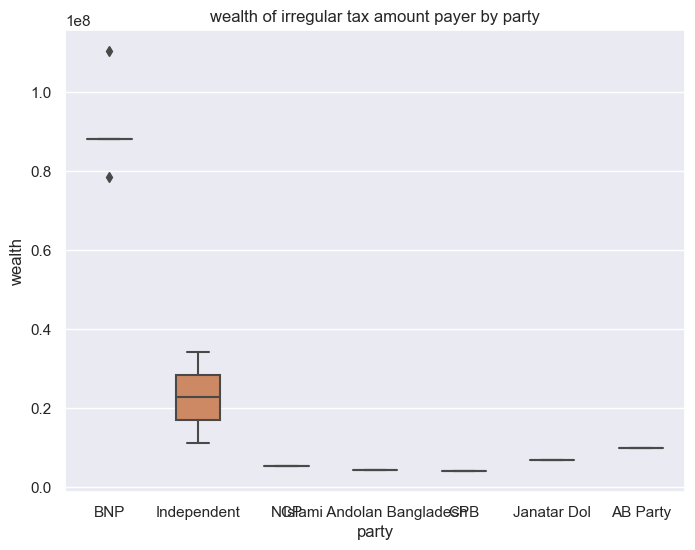

In [14]:
# plot distribution of wealth of irregular tax amount payer by party
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=dfnottax, x="party", y="wealth", width=.5, ax=ax)
ax.set_title('wealth of irregular tax amount payer by party')
ax.set_ylabel('wealth')
fig.savefig('fig/affidavit_tax_irregular_wealth_by_party',bbox_inches='tight')

In [15]:
dftax_med = dfa[dfa['check_tax']<=0.5][['wealth', 'income', 'tax']].dropna().median()
dfnottax_med = dfa[dfa['check_tax']>0.5][['wealth', 'income', 'tax']].dropna().median()

dft_med = pd.concat([dftax_med, dfnottax_med]).reset_index()
dft_med.columns = ['metric', 'value']
dft_med['category'] = ['regular']*3 + ['irregular']*3
dft_med

,metric,value,category
0,wealth,4817960.0,regular
1,income,480000.0,regular
2,tax,7135.5,regular
3,wealth,11206062.0,irregular
4,income,9665195.0,irregular
5,tax,168298.0,irregular


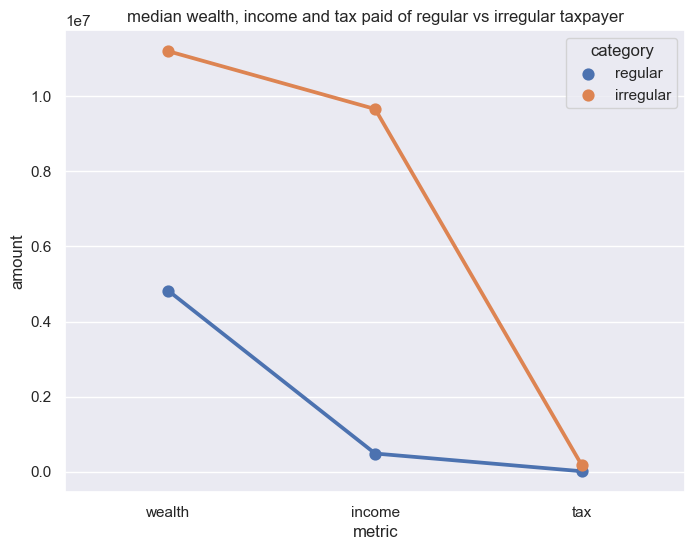

In [16]:
# plot median tax paid, income shown and wealth of irregular tax amount payers
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(data=dft_med, x="metric", y="value", hue="category")
ax.set_title('median wealth, income and tax paid of regular vs irregular taxpayer')
ax.set_ylabel('amount')
fig.savefig('fig/affidavit_tax_med_comparison',bbox_inches='tight')